In [48]:
from pypylon import pylon
from pypylon import genicam
import cv2
import sys
from IPython.display import clear_output
import os
import torch #should be installed by default in any colab notebook
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from time import time
import pandas as pd
import sklearn as sk
import json
import h5py

assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Used device {device}")


import ctypes
import gc

def free():
    gc.collect()
    torch.cuda.empty_cache()
    libc = ctypes.CDLL("libc.so.6")
    libc.malloc_trim(0)
    gc.collect()
    torch.cuda.empty_cache()
    libc = ctypes.CDLL("libc.so.6")
    libc.malloc_trim(0)

Used device cuda:0


In [81]:
import scipy
import skopt
import sklearn.linear_model
from skimage.transform import warp_polar

def angle_to_pi_pi( angle): # convert any angle to range (-pi,pi]\n",
    angle= angle%(2*np.pi) # take it to [-2pi, 2pi]\n",
    return angle-np.sign(angle)*2*np.pi if abs(angle)>np.pi else angle

def get_histo_and_fit(center_h_w, im, ransac, theta_N, rad_N, max_rad, rad_scaling, interpol_order, ransac_opts=None): # get the least square error of a fit with a 
    # y=Acos**2(x/2-phi0)+B=b0+b1 cos(x)+b2 sin(x) if b0=A/2+B; b1=A/2 cos(2phi0); b2=A/2sin(2phi0)
    im_polar = warp_polar(im, center=center_h_w, 
                    output_shape=(theta_N, rad_N), 
                    radius=max_rad,
                    scaling=rad_scaling,
                    order=interpol_order)
    hist = im_polar.sum(axis=1)
    supp_phis = np.linspace(0, np.pi*2, theta_N)
    if ransac:
        A = np.vstack((np.ones(len(hist)), np.cos(supp_phis), np.sin(supp_phis))).T
        betas = sk.linear_model.RANSACRegressor(base_estimator=sklearn.linear_model.LinearRegression(),
                    min_samples=ransac_opts['min_samples'], max_trials=ransac_opts['max_trials'], 
                    residual_threshold=ransac_opts['residual_threshold'],
                    #stop_n_inliers=inf, stop_score=inf, stop_probability=0.99, loss='absolute_error',
                    random_state=666)
        betas = betas.fit(A[:,1:], hist)
        ls_res = np.sum( betas.score(A[:,1:], hist)  )
    else:
        betas=None
        ls_res = None
    return ls_res, betas, hist, supp_phis

def rotate_image_by( image_array, angle, center,interpolation_flag):
        """
        Center is expected to be a point [h,w]
        """
        a=np.cos(angle)
        b=np.sin(angle)
        rot_mat=np.float64([[a, b, center[1]*(1-a)-center[0]*b],
                             [-b, a, center[1]*b+center[0]*(1-a)]])
        return cv2.warpAffine(image_array, rot_mat, image_array.shape, flags=interpolation_flag).astype(image_array.dtype)
     
        
def get_Carles_metric(center_h_w, im,  interpolation_flag):
    im_pi_im = rotate_image_by(im, np.pi, center_h_w,interpolation_flag)+im
    return np.mean(np.abs(im_pi_im-rotate_image_by(im_pi_im, np.pi/2, center_h_w,interpolation_flag)))


def get_geomcenter_angular_prof(image, preprocess_fct, get_grav_fct, blazq_alg_kw_args):
    image = preprocess_fct( image )
    grav_center = get_grav_fct(image) #[N_pbs, 2]

    # run it
    get_fit = lambda c_h_w, im : get_histo_and_fit(c_h_w, im, ransac=blazq_alg_kw_args['ransac'],
                                            ransac_opts=blazq_alg_kw_args['ransac_opts'],
                                            theta_N=blazq_alg_kw_args['theta_N'],
                                            rad_N=blazq_alg_kw_args['rad_N'],
                                            max_rad=blazq_alg_kw_args['max_rad'],
                                            rad_scaling=blazq_alg_kw_args['rad_scaling'], 
                                            interpol_order=blazq_alg_kw_args['interpolation_order'])

    get_metric = lambda c_h_w, im : get_Carles_metric(c_h_w, im, interpolation_flag=cv2.INTER_CUBIC)
    
    options={'maxiter':blazq_alg_kw_args['max_it'],
                'maxfev': blazq_alg_kw_args['max_evals']}
        
    if blazq_alg_kw_args['method']=='Nelder-Mead':
        options['xatol']=blazq_alg_kw_args['abs_tol']
        options['fatol']=blazq_alg_kw_args['rel_tol']
    elif blazq_alg_kw_args['method']=='Powell':
        options['xtol']=blazq_alg_kw_args['abs_tol']
        options['ftol']=blazq_alg_kw_args['rel_tol']

    t0=time()
    to_opt = lambda c_h_w : get_metric(c_h_w, im=image)

    res = scipy.optimize.minimize(to_opt, grav_center, method=blazq_alg_kw_args['method'],
                                    bounds=((0,image.shape[0]),(0, image.shape[0])),
                                    #constraints=(), 
                                    tol=None, options=options)
    geom_center = res.x

                
    fitted_er, betas, angular_profile, supp_phis = get_fit(geom_center, image)
    if blazq_alg_kw_args['ransac']:
        angle_ransac = np.arctan2(betas.estimator_.coef_[1],betas.estimator_.coef_[0])
        fitted = betas.estimator_.predict(np.vstack(( np.cos(supp_phis), np.sin(supp_phis))).T)
    else:
        fitted = None
        angle_ransac=None
        betas = None
        
    if blazq_alg_kw_args['get_grav_angle']:
        ang_grav_geom = np.arctan2(geom_center[0]-grav_center[0], geom_center[1]-grav_center[1] )
        rows_prec = np.broadcast_to( 
            np.arange(image.shape[1]), (image.shape[1],image.shape[1])).swapaxes(0,1) #[h,w]
        ang_grav_geom = get_polarization_angle( ang_grav_geom, image, grav_center, rows_prec)
    else:
        ang_grav_geom = None
    
    t0 = time()-t0
    
    return geom_center, grav_center, angular_profile, fitted, betas, ang_grav_geom, angle_ransac, fitted_er, t0, supp_phis
    
     
def given_axis_angle_greater_minus_lower( angle, image, center, rows):
    # such that if the output is positive, then R has more intensity and you know immediately that the good angle is the bigger one?
    # de fet esto sugiere un algoritmo con el polano ortogonal que directamente te encuentra el angulo que toca, pero bueno con los que buscan el eje simetrico el truco no parece que funcionara
    mask=np.less(rows, np.tan(angle)*(rows.swapaxes(0,1)-center[1])+center[0]) #[h,w] We set -angle, because the coordinates we are thinking of are a mirror flip in w
        # also, we use less instead of greater because we are really thinking on the mirror fliped axes on w
    return np.sum(image[mask])-np.sum(image[np.logical_not(mask)])

def get_polarization_angle( angle, image, center, rows):
    """
    All the mirror methods have the problem that we only get the
    correct angle up to an angle pi. In order to know which is the
    angle to the maximum of the ring (and not the minimum) a final
    subtle check is required.
    """
    #if angle==np.pi or 0: In this case the correct one is not defined by this alg!!!
    if angle==0 or abs(angle)==np.pi:
        angle+=1e-12 # this solution is not ideal, but it works, since we will never get such a good precision
    diff=given_axis_angle_greater_minus_lower(angle+np.pi/2, image, center, rows)

    if diff<0: # then Upper>Lower -> then good one is the one in (0,pi)
        return angle+np.pi if angle<0 else angle
    else:
        return angle-np.pi if angle>0 else angle 
    
    
def compute_intensity_gravity_center(image):
    """
        Expects input image to be an array of dimensions [h, w].
        It will return an array of gravity centers [2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to numpy indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = np.sum(image, axis=0) # weights for x [raw_width]
    intensity_in_h = np.sum(image, axis=1) # weights for y [raw_height]
    total_intensity = intensity_in_h.sum()

    # Compute mass center for intensity
    # [2] (h_center,w_center)
    return np.nan_to_num( np.stack(
        (np.dot(intensity_in_h, np.arange(image.shape[0]))/total_intensity,
         np.dot(intensity_in_w, np.arange(image.shape[1]))/total_intensity)
        ) )

def preprocess_fct(image):
    return image.astype(np.float64)/np.max(image)

###################################################################################
###################################################################################
###################################################################################
###################################################################################




# Un embedder aqui solo tiene sentido si ha estado fed con ground truth poarization angles

class Simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center():
    
    def center_in_center_torch(self, image, center): # For a piling of images and centers
        # crop the iamges with size (X+1+X)^2 leaving the gravity center in
        # the central pixel of the image. In case the image is not big enough for the cropping,
        # a 0 padding will be made.
        centered_image = torch.zeros( ( 2*X+1, 2*X+1),  dtype = image.dtype, 
                                      device=device)

        # we round the gravity centers to the nearest pixel indices
        g_index_raw = torch.round(center).int() #[ N_images, 2]

        # obtain the slicing indices around the center of gravity
        # TODO -> make all this with a single array operation by stacking the lower and upper in
        # a new axis!!
        # [ N_images, 2 (h,w)]
        unclipped_lower = g_index_raw-X
        unclipped_upper = g_index_raw+X+1

        # unclipped could get out of bounds for the indices, so we clip them
        lower_bound = torch.clip( unclipped_lower.float(), min=torch.tensor([[0,0]], device=device),
                                 max=torch.tensor(list(image.shape), device=device) ).int()
        upper_bound = torch.clip( unclipped_upper.float(), min=torch.tensor([[0,0]], device=device),
                                 max=torch.tensor(list(image.shape), device=device) ).int()
        # we use the difference between the clipped and unclipped to get the necessary padding
        # such that the center of gravity is left still in the center of the image
        padding_lower = lower_bound-unclipped_lower
        padding_upper = upper_bound-unclipped_upper

        # crop the image
        centered_image[ padding_lower[0, 0]:padding_upper[0, 0] or None,
                                        padding_lower[0, 1]:padding_upper[0, 1] or None] = \
                      image[ lower_bound[0,  0]:upper_bound[0, 0],
                                          lower_bound[0, 1]:upper_bound[0, 1]]

        return centered_image
    
    def rotate_image_by(  self, image_array, angle, center,interpolation_flag):
        """
        Center is expected to be a point [h,w]
        """
        a=np.cos(angle)
        b=np.sin(angle)
        rot_mat=np.float64([[a, b, center[1]*(1-a)-center[0]*b],
                             [-b, a, center[1]*b+center[0]*(1-a)]])
        return cv2.warpAffine(image_array, rot_mat, image_array.shape, flags=interpolation_flag).astype(image_array.dtype)


    def get_Carles_metric( self, center_h_w, im,  interpolation_flag):
        im_pi_im = self.rotate_image_by(im, np.pi, center_h_w,interpolation_flag)+im
        return np.mean(np.abs(im_pi_im-rotate_image_by(im_pi_im, np.pi/2, center_h_w,interpolation_flag)))


    def initial_Blazquez_estimation( self,  im, center, options_Blaz, rows_prec ):
        get_metric = lambda c_h_w : self.get_Carles_metric(c_h_w, im=im, interpolation_flag=cv2.INTER_CUBIC)
        res = scipy.optimize.minimize(get_metric, center, method='Nelder-Mead',
                                            bounds=((0,im.shape[0]),(0, im.shape[0])),
                                            tol=None, options=options_Blaz)
        geom_center = res.x
        angle = np.arctan2(geom_center[0]-center[0], geom_center[1]-center[1] )
        angle = self.get_polarization_angle( angle, im, center, rows_prec)
        max_pix_in_prof = np.argmax(im[ int(geom_center[0]),:])
        R0 = np.abs(max_pix_in_prof-geom_center[1])-3
        if max_pix_in_prof>geom_center[1]:
            tol = im[ int(geom_center[0]),::-1]>0.4
        else:
            tol = im[ int(geom_center[0]),:]>0.4
        init = np.argwhere(tol)[0,0]
        w0 = np.argwhere(np.logical_not(tol[init:]))[0,0]
        #print(f"Initial Blazquez Estim.: phi{-angle} R0{R0} w0{w0}")
        return -angle, R0, w0, geom_center

    def get_simulated_image( self, R0, w0, Z, phiCR):
        if self.last_R0!=R0 or self.last_w0!=w0 or self.last_Z!=Z:
            name = f"R0_{self.closest_in_ar_periodic(R0,self.R0s_ar, self.R0_precision)}_w0_{self.closest_in_ar_periodic(w0, self.w0s_ar, self.w0_precision)}_Z_{self.closest_in_ar_periodic(Z, self.Zs_ar, self.Z_precision)}"
            self.D_mats = torch.from_numpy(self.h5f_D_matrices[name][:]
                    ).unsqueeze(1).to(device) #[2, 1, h, w]            
            self.last_R0 = R0
            self.last_w0 = w0
            self.last_Z = Z
        phiCRs = torch.tensor([angle_to_pi_pi(phiCR)]).to(device) #[num_phiCR, 1, 1]
        images = self.D_mats[0]+self.D_mats[1]*torch.cos(phiCRs-self.phis) #[num_phiCR, Nx,Ny]
        images = self.postgeom_preprocess_fct(images, in_are_dev_float=True)[0] # only one image
        return torch.nn.functional.pad(images, (33,32,33,32), mode='constant', value=0)
    
    def closest_in_ar_periodic(  self, value, list_array, delta):
        idxs = (np.round((value-min(list_array))/delta)%len(list_array)).astype(int)
        return list_array[ idxs ]
    
    def plot_found_and_ref( self, im_exp, R0, w0, Z, phi):
        if self.last_R0!=R0 or self.last_w0!=w0 or self.last_Z!=Z:
            name = f"R0_{self.closest_in_ar_periodic(R0,self.R0s_ar, self.R0_precision)}_w0_{self.closest_in_ar_periodic(w0, self.w0s_ar, self.w0_precision)}_Z_{self.closest_in_ar_periodic(Z, self.Zs_ar, self.Z_precision)}"
            self.D_mats = torch.from_numpy(self.h5f_D_matrices[name][:]
                    ).unsqueeze(1).to(device) #[2, 1, h, w]            
            self.last_R0 = R0
            self.last_w0 = w0
            self.last_Z = Z
        im_polar = warp_polar(im_exp, center=[im_exp.shape[0]//2,im_exp.shape[1]//2], 
                    output_shape=(3600, 50), 
                    radius=2*im_exp.shape[0]//3,
                    scaling='linear',
                    order=3)
        hist = im_polar.sum(axis=1)
        phiCRs = torch.tensor([angle_to_pi_pi(phi)]).to(device) #[num_phiCR, 1, 1]
        im_sim = self.D_mats[0]+self.D_mats[1]*torch.cos(phiCRs-self.phis) #[num_phiCR, Nx,Ny]
        im_sim = torch.nn.functional.pad(
            self.postgeom_preprocess_fct(im_sim, in_are_dev_float=True)[0],
            (33,32,33,32), mode='constant', value=0).to('cpu').numpy()
        clear_output(wait=True)
        fig, ax = plt.subplots(1,3,figsize=(15,5))
        ax[0].imshow(im_exp)
        ax[0].set_title("Experimental Image")
        ax[1].imshow(im_sim)
        ax[1].set_title(f"Found optimal Simulation\nR0={R0:.3} w0={w0:.3}\n Z={Z:.3}\n phi={phi:.3}")
        ax[2].plot( np.linspace(0,2*np.pi, len(hist)), hist)
        ax[2].set_title("Angular Histogram from Geom Cent")
        plt.show()
    
    def compute_metric(self, R0_w0_Z_phi, exp_image):
        #self.plot_found_and_ref(exp_image.to('cpu').numpy(),R0_w0_Z_phi[0], R0_w0_Z_phi[1], R0_w0_Z_phi[2], R0_w0_Z_phi[3])
        return self.similarity_func( exp_image, 
                        self.get_simulated_image(R0_w0_Z_phi[0], R0_w0_Z_phi[1], R0_w0_Z_phi[2], R0_w0_Z_phi[3]) )
    
    def closest_idx_in_ar(self, value, list_array): # hay que meterle una periodicidad como con los angulos porke los algs de optimizacion están pensados para que así sea
        return (np.abs(list_array-value)).argmin()


    def given_axis_angle_greater_minus_lower(self, angle, image, center, rows):
        # such that if the output is positive, then R has more intensity and you know immediately that the good angle is the bigger one?
        # de fet esto sugiere un algoritmo con el polano ortogonal que directamente te encuentra el angulo que toca, pero bueno con los que buscan el eje simetrico el truco no parece que funcionara
        mask=np.less(rows, np.tan(angle)*(rows.swapaxes(0,1)-center[1])+center[0]) #[h,w] We set -angle, because the coordinates we are thinking of are a mirror flip in w
        # also, we use less instead of greater because we are really thinking on the mirror fliped axes on w
        return np.sum(image[mask])-np.sum(image[np.logical_not(mask)])

    def get_polarization_angle(self, angle, image, center, rows):
        """
        All the mirror methods have the problem that we only get the
        correct angle up to an angle pi. In order to know which is the
        angle to the maximum of the ring (and not the minimum) a final
        subtle check is required.
        """
        #if angle==np.pi or 0: In this case the correct one is not defined by this alg!!!
        if angle==0 or abs(angle)==np.pi:
            angle+=1e-12 # this solution is not ideal, but it works, since we will never get such a good precision
        diff=given_axis_angle_greater_minus_lower(angle+np.pi/2, image, center, rows)

        if diff<0: # then Upper>Lower -> then good one is the one in (0,pi)
            return angle+np.pi if angle<0 else angle
        else:
            return angle-np.pi if angle>0 else angle

    
    def __init__(self, pregeom_preprocess_fct, postgeom_preprocess_fct, simulation_fit_kw_args, embedder=None, preprocess_simulated=None):

        if embedder is None:
            self.process = preprocess_fct
            self.pregeom_preprocess_fct = pregeom_preprocess_fct
            self.postgeom_preprocess_fct = postgeom_preprocess_fct
        else:
            self.process = postgeom_preprocess_fct
            self.postgeom_preprocess_fct = lambda im, in_are_dev_float : self.embedder(self.process( im, in_are_dev_float ))
            self.pregeom_preprocess_fct = pregeom_preprocess_fct
        self.simulation_fit_kw_args = simulation_fit_kw_args
        self.embedder = embedder
        
        self.X = simulation_fit_kw_args['X']
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(simulation_fit_kw_args['ID_file_path'])))       
        self.R0s = list(self.df_GTs['R0s'].drop_duplicates()) # Note they are lists of strings!
        self.w0s = list(self.df_GTs['w0s'].drop_duplicates())
        self.Zs = list(self.df_GTs['Zs'].drop_duplicates())
        self.R0s_ar = np.array(self.R0s, dtype=np.float64) # Convert them to float arrays
        self.w0s_ar = np.array(self.w0s, dtype=np.float64)
        self.Zs_ar = np.array(self.Zs, dtype=np.float64)

        self.h5f_D_matrices = h5py.File( simulation_fit_kw_args['D_matrix_file_path'], 'r')
        self.phis = torch.from_numpy( self.h5f_D_matrices['phis'][:]).unsqueeze(0).to(device) #[1,Nx,Ny]

        self.min_Z=min(self.Zs_ar)
        self.max_Z=max(self.Zs_ar)
        self.min_phi=-np.pi
        self.max_phi=np.pi
        self.min_radi=min(self.R0s_ar)
        self.max_radi=max(self.R0s_ar)
        self.min_w0=min(self.w0s_ar)
        self.max_w0=max(self.w0s_ar)
        #print((self.min_radi,self.max_radi),(self.min_w0,self.max_w0), (self.min_Z, self.max_Z), (self.min_phi, self.max_phi))

        self.last_R0=None
        self.last_w0=None
        self.last_Z=None
        self.R0_precision=abs(self.R0s_ar[1]-self.R0s_ar[0])
        self.w0_precision=abs(self.w0s_ar[1]-self.w0s_ar[0])
        self.Z_precision=abs(self.Zs_ar[1]-self.Zs_ar[0])
        self.similarity_func=simulation_fit_kw_args['similarity_alg']


    @torch.no_grad()
    def get_geom_and_simul(self, image):

        image_t = self.pregeom_preprocess_fct( torch.from_numpy(image), in_are_dev_float=False )

        gcenter_t = compute_intensity_gravity_center_torch( image_t) #[ 2] in numpy but input in torch
        image_t = self.center_in_center_torch(image_t, gcenter_t) # center in gravicentrum!
                                              
        grav_center= gcenter_t.to('cpu').numpy()

        image = image_t.to('cpu').numpy()

        
        # Blazquez algorithm estimation of phiCR, R0 (and even w0)
        options_Blaz={'maxiter':self.simulation_fit_kw_args['max_it_Blaz'],
                 'maxfev': self.simulation_fit_kw_args['max_evals_Blaz'], 
                 'xatol':self.simulation_fit_kw_args['abs_tol_Blaz'],
                 'fatol':self.simulation_fit_kw_args['rel_tol_Blaz']}
        rows_prec = np.broadcast_to( 
            np.arange(image.shape[1]), (image.shape[1],image.shape[1])).swapaxes(0,1) #[h,w]
                                              
        t0=time()
            
        Z_guess = 0
        phi_guess, R0_guess, w0_guess, geom_center = self.initial_Blazquez_estimation( image, grav_center, options_Blaz, rows_prec )
        R0_guess = self.min_radi if R0_guess<self.min_radi else self.max_radi if R0_guess>self.max_radi else R0_guess
        w0_guess = self.min_w0 if w0_guess<self.min_w0 else self.max_w0 if w0_guess>self.max_w0 else w0_guess
        init_guess = [ R0_guess, w0_guess, Z_guess, phi_guess ]
        
        #ref_im = self.center_in_center(ref_im, geom_center_ref)
        #pb_im = self.center_in_center(pb_im, geom_center_pb)
        image_t = self.center_in_center_torch( image_t, torch.from_numpy(geom_center).to(device) )

        image_t = self.postgeom_preprocess_fct(image_t, True)
            
        image = image_t.to('cpu').numpy()
            
        to_opt = lambda R0_w0_Z_phi : self.compute_metric(R0_w0_Z_phi, exp_image=image_t )

        options={'maxiter':self.simulation_fit_kw_args['max_it'],
            'maxfev': self.simulation_fit_kw_args['max_evals']}

        if self.simulation_fit_kw_args['method']=='Nelder-Mead':
            options['xatol']=self.simulation_fit_kw_args['abs_tol']
            options['fatol']=self.simulation_fit_kw_args['rel_tol']
        elif self.simulation_fit_kw_args['method']=='Powell':
            options['xtol']=self.simulation_fit_kw_args['abs_tol']
            options['ftol']=self.simulation_fit_kw_args['rel_tol']

        res = scipy.optimize.minimize(to_opt, init_guess, method=self.simulation_fit_kw_args['method'],
                 bounds=((self.min_radi,self.max_radi),(self.min_w0,self.max_w0), (self.min_Z, self.max_Z), (self.min_phi, self.max_phi)),
                                #constraints=(), 
                                tol=None, options=options)
        opt_R0w0ZphiCR = res.x
        self.plot_found_and_ref(image, opt_R0w0ZphiCR[0],opt_R0w0ZphiCR[1],opt_R0w0ZphiCR[2],opt_R0w0ZphiCR[3])            

        t0 = time()-t0

        return opt_R0w0ZphiCR, t0
    
    def __del__(self):
        self.h5f_D_matrices.close()    

    
def pregeom_preprocess_fct(images, in_are_dev_float, dtype=torch.float64):
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
        free()
    return images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))

def postgeom_preprocess_fct(images, in_are_dev_float, dtype=torch.float64):
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
        free()
    return images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))
                                              
def compute_intensity_gravity_center_torch( image):
    """
        Expects input image to be an array of dimensions [N_imgs, h, w].
        It will return an array of gravity centers [N_imgs, 2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to array indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = torch.sum(image, dim=0) # weights for x [N_images, raw_width]
    intensity_in_h = torch.sum(image, dim=1) # weights for y [N_images, raw_height]
    total_intensity = intensity_in_h.sum() # [N_images]

    # Compute mass center for intensity
    # [N_images, 2] (h_center,w_center)
    return torch.nan_to_num( torch.stack(
        (torch.matmul(intensity_in_h.float(), torch.arange(image.shape[0], 
                                    dtype=torch.float32, device=device))/total_intensity,
         torch.matmul(intensity_in_w.float(), torch.arange(image.shape[1], 
                                    dtype=torch.float32, device=device))/total_intensity)
        ), nan=0.0, posinf=None, neginf=None)

# Take Images, Obtain Geometric Center and Angular Profile
## (RANSAC $cos^2$ fit optional)
The metric of the fit could aid in deciding when a real cos^2 is achieved.

In [77]:
blazq_alg_kw_args = {'rad_scaling':'linear', 'interpolation_order':3, 
                    'theta_N':360*10**1, 'rad_N':50, 
                    'method':'Nelder-Mead', 'get_grav_angle':True,
                   'max_it':30, 'max_evals':50, 'abs_tol':0, 'rel_tol':0,
                   'get_delta_from_grav_geom_centers':False, 'ransac':True, 
                'ransac_opts':{'min_samples':0.5, 'max_trials':80, 'residual_threshold':0.1}} # 0.7 0.3

# Cam params
exposure_time = 700

# Number of images to be grabbed.
countOfImagesToGrab = 100000000000
one_every = 1 # Average these number of images before running

output_path=f"/home/melanie/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/New_Day/{exp_name}"
os.makedirs(output_path, exist_ok=True)

try:
    
    # Create an instant camera object with the camera device found first.
    camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
    camera.Open()

    # Print the model name of the camera.
    print("Using device ", camera.GetDeviceInfo().GetModelName())

    # The parameter MaxNumBuffer can be used to control the count of buffers
    # allocated for grabbing. The default value of this parameter is 10.
    camera.MaxNumBuffer = 1
    camera.ExposureTime.SetValue(exposure_time)

    # Start the grabbing of c_countOfImagesToGrab images.
    # The camera device is parameterized with a default configuration which
    # sets up free-running continuous acquisition.
    camera.StartGrabbingMax(countOfImagesToGrab)

    # Camera.StopGrabbing() is called automatically by the RetrieveResult() method
    # when c_countOfImagesToGrab images have been retrieved.
    
    # grab example image to get w and h
    # Wait for an image and then retrieve it. A timeout of 5000 ms is used.
    grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)
    w = grabResult.Width
    h = grabResult.Height
    print(f"Taking images of w={w} h={h}")
    
    blazq_alg_kw_args['max_rad'] = 2*w//3
    i=0
    img = np.zeros((h,w), dtype=np.float64)

    while camera.IsGrabbing():
        # Wait for an image and then retrieve it. A timeout of 5000 ms is used.
        grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)
        # Image grabbed successfully?
        if True: ##grabResult.GrabSucceeded():
            i+=1
            # Access the image data.
            img += grabResult.Array
            if i % one_every==one_every-1: # every one_every images run alg
                img/=one_every
                geom, grav, angular_profile, fitted, betas, ang_grav_geom, ang_ransac, fitted_er, t0, supp_phis = \
                        get_geomcenter_angular_prof( img, preprocess_fct, compute_intensity_gravity_center, blazq_alg_kw_args )

                clear_output(wait=True)
                fig, axs = plt.subplots(1, 2, figsize=(20,5))
                axs[0].imshow(img)
                axs[0].set_title("Raw Exp Img")
                axs[0].plot(geom[1],geom[0], 'or', label="Geometric Center")
                axs[0].plot(grav[1],grav[0], 'oy', label="Gravicenter")
                axs[0].plot([0,img.shape[0]-1],[-grav[1]*(geom[0]-grav[0])/(geom[1]-grav[1])+grav[0], (img.shape[0]-1-grav[1])*(geom[0]-grav[0])/(geom[1]-grav[1])+grav[0]], '-w')
                axs[0].set_xlim((0, img.shape[1]))
                axs[0].set_ylim((0, img.shape[0]))
                #axs[1].imshow(img_in_geometric_center)
                #axs[1].set_title("Exp Image Centered in Geometric Center")
                if blazq_alg_kw_args['ransac']:
                    print(f"RANSAC ERROR: {fitted_er:.3} n trials: {betas.n_trials_} inliers: {np.sum(betas.inlier_mask_)}")
                    axs[1].plot(supp_phis[betas.inlier_mask_], np.zeros(np.sum(betas.inlier_mask_)), 'o', markersize=1, label="Inliers")
                axs[1].plot(supp_phis, angular_profile, label="Histogram at optimal geometric center")
                axs[1].plot(supp_phis, fitted, label="Least Squares Fit")
                axs[1].legend()
                axs[1].set_title("Angular Histogram From Geometric Center")
                plt.show()
                
                print(f"Image Num {i} of w={w} h={h}")
                print(f"Sum Full Image Pixels {img.sum()} ")
                print(f"Sum of pixels in the four quadrants around the geometric center:")
                geom=geom.astype(int)
                print(f"TL : {img[:geom[0], :geom[1]].sum()} TR: {img[:geom[0], geom[1]:].sum()}")
                print(f"BL : {img[geom[0]:, :geom[1]].sum()} BR: {img[geom[0]:, geom[1]:].sum()}")
                print(f"Time taken {t0:.3}s \nAngle estimates: ransac={ang_ransac/np.pi*180:.3}deg grav={ang_grav_geom/np.pi*180:.3}deg")
                img = np.zeros((h,w), dtype=np.float64)
                
        else:
            print("Error: ", grabResult.ErrorCode, grabResult.ErrorDescription)
        grabResult.Release()
    camera.Close()

except genicam.GenericException as e:
    # Error handling.
    print("An exception occurred.")
    print(e.GetDescription())

An exception occurred.


AttributeError: 'RuntimeException' object has no attribute 'GetDescription'

# Take Images, Obtain Geometric Center and Simulation Fit

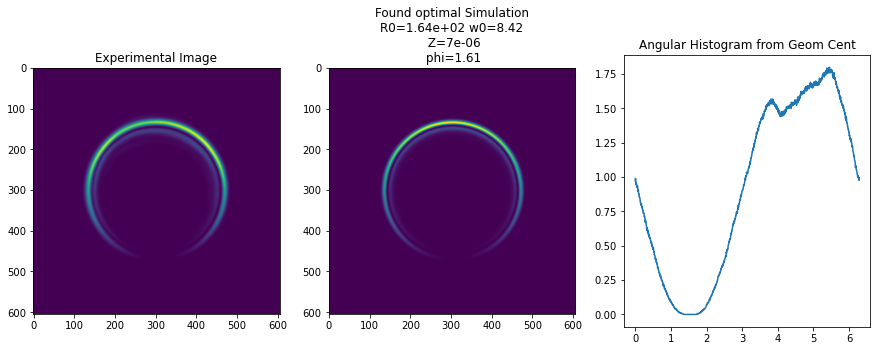

Image Num 30 of w=605 h=605
Sum Full Image Pixels 1695548 
Time taken 1.33s 
Angle estimates: 92.2 


KeyboardInterrupt: 

In [82]:
ID_file_path = "/media/melanie/D459-5113/STRUCTURE_Grid_R0_70_w0_70_Z_4.json"
D_matrix_file_path = "/media/melanie/D459-5113/Dataset_R0_70_w0_70_Z_4.h5"
X=302
simulation_fit_kw_args_NM = {'ID_file_path':ID_file_path , 'D_matrix_file_path':D_matrix_file_path, 'device':device,
                             'similarity_alg':lambda im1, im2: torch.sum(torch.abs(im1-im2)).item(),
                            'use_exact_gravicenter':True, 'X':X,
            'gravicenter_alg': lambda ims: compute_intensity_gravity_centers_torch( ims ).to('cpu').numpy(),
                              'method':'Nelder-Mead',
                             'max_it':70, 'max_evals':100, 'abs_tol':0, 'rel_tol':0,
                             'max_it_Blaz':40, 'max_evals_Blaz':40, 'abs_tol_Blaz':0, 'rel_tol_Blaz':0}
# Cam params
exposure_time = 700

# Number of images to be grabbed.
countOfImagesToGrab = 100000000000
one_every = 1 # Average these number of images before running

output_path=f"/home/melanie/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/New_Day/{exp_name}"
os.makedirs(output_path, exist_ok=True)

alg = Simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center(pregeom_preprocess_fct,
                       postgeom_preprocess_fct, simulation_fit_kw_args_NM, embedder=None, preprocess_simulated=None)


try:
    # Create an instant camera object with the camera device found first.
    camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
    camera.Open()

    # Print the model name of the camera.
    print("Using device ", camera.GetDeviceInfo().GetModelName())

    # The parameter MaxNumBuffer can be used to control the count of buffers
    # allocated for grabbing. The default value of this parameter is 10.
    camera.MaxNumBuffer = 1
    camera.ExposureTime.SetValue(exposure_time)

    # Start the grabbing of c_countOfImagesToGrab images.
    # The camera device is parameterized with a default configuration which
    # sets up free-running continuous acquisition.
    camera.StartGrabbingMax(countOfImagesToGrab)

    # Camera.StopGrabbing() is called automatically by the RetrieveResult() method
    # when c_countOfImagesToGrab images have been retrieved.
    
    # grab example image to get w and h
    # Wait for an image and then retrieve it. A timeout of 5000 ms is used.
    grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)
    w = grabResult.Width
    h = grabResult.Height
    print(f"Takin images of w={w} h={h}")
    
    blazq_alg_kw_args['max_rad'] = 2*w//3
    i=0
    img = np.zeros((h,w), dtype=np.float64)

    while camera.IsGrabbing():
        # Wait for an image and then retrieve it. A timeout of 5000 ms is used.
        grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)

        # Image grabbed successfully?
        if grabResult.GrabSucceeded():
            # Access the image data.
            i+=1
            # Access the image data.
            img += grabResult.Array
            if i % one_every==one_every-1: # every one_every images run alg
                img/=one_every
                opt_R0w0ZphiCR, t0 = alg.get_geom_and_simul(img)                
                print(f"Image Num {i} of w={w} h={h}")
                print(f"Sum Full Image Pixels {img.sum()} ")
                print(f"Time taken {t0:.3}s \nAngle estimates: {opt_R0w0ZphiCR[-1]/np.pi*180:.3} ")
                img = np.zeros((h,w), dtype=np.float64)
                
        else:
            print("Error: ", grabResult.ErrorCode, grabResult.ErrorDescription)
        grabResult.Release()
    camera.Close()

except genicam.GenericException as e:
    # Error handling.
    print("An exception occurred.")
    print(e.GetDescription())

# Take Images, Show and Save Live

In [ ]:
# Cam params
exposure_time = 700

# Number of images to be grabbed.
countOfImagesToGrab = 100000000000
one_every=40 # save an image every X shown ones
photos_to_save=200
j=0 # count of the saved images

exp_name=""
img_prefix=""

output_path=f"/home/melanie/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/New_Day/{exp_name}"
os.makedirs(output_path, exist_ok=True)

try:
    # Create an instant camera object with the camera device found first.
    camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
    camera.Open()

    # Print the model name of the camera.
    print("Using device ", camera.GetDeviceInfo().GetModelName())

    # The parameter MaxNumBuffer can be used to control the count of buffers
    # allocated for grabbing. The default value of this parameter is 10.
    camera.MaxNumBuffer = 1
    camera.ExposureTime.SetValue(exposure_time)

    # Start the grabbing of c_countOfImagesToGrab images.
    # The camera device is parameterized with a default configuration which
    # sets up free-running continuous acquisition.
    camera.StartGrabbingMax(countOfImagesToGrab)

    # Camera.StopGrabbing() is called automatically by the RetrieveResult() method
    # when c_countOfImagesToGrab images have been retrieved.
    
    # grab example image to get w and h
    # Wait for an image and then retrieve it. A timeout of 5000 ms is used.
    grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)
    w = grabResult.Width
    h = grabResult.Height
    print(f"Takin images of w={w} h={h}")
    
    i=0
    while camera.IsGrabbing():
        i+=1
        # Wait for an image and then retrieve it. A timeout of 5000 ms is used.
        grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)

        # Image grabbed successfully?
        if grabResult.GrabSucceeded():
            # Access the image data.
            img = grabResult.Array
            cv2.imshow("{i}", img)
            cv2.waitKey(2)
            if i%one_every==0: # every one_every images save one
                print(43*'\n')
                print(f"Sum Full Image Pixels {img.sum()} ")
                cv2.imwrite(f"{output_path}/{img_prefix}_{j}.png", img)
                j+=1
                if j>=photos_to_save:
                    break
        else:
            print("Error: ", grabResult.ErrorCode, grabResult.ErrorDescription)
        grabResult.Release()
    camera.Close()

except genicam.GenericException as e:
    # Error handling.
    print("An exception occurred.")
    print(e.GetDescription())

# Test Stuff

In [36]:
blazq_alg_kw_args = {'rad_scaling':'linear', 'interpolation_order':3, 
                    'theta_N':360*10**1, 'rad_N':50, 
                    'method':'Nelder-Mead', 'get_grav_angle':True,
                   'max_it':30, 'max_evals':50, 'abs_tol':0, 'rel_tol':0,
                   'get_delta_from_grav_geom_centers':False, 'ransac':True, 
                'ransac_opts':{'min_samples':0.5, 'max_trials':80, 'residual_threshold':0.05}}

# Cam params
exposure_time = 700

# Number of images to be grabbed.
countOfImagesToGrab = 100000000000
one_every = 1# Apply to one every

exp_name=""
img_prefix=""

output_path=f"/home/melanie/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/New_Day/{exp_name}"
os.makedirs(output_path, exist_ok=True)

try:
    '''
    # Create an instant camera object with the camera device found first.
    camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
    camera.Open()

    # Print the model name of the camera.
    print("Using device ", camera.GetDeviceInfo().GetModelName())

    # The parameter MaxNumBuffer can be used to control the count of buffers
    # allocated for grabbing. The default value of this parameter is 10.
    camera.MaxNumBuffer = 1
    camera.ExposureTime.SetValue(exposure_time)

    # Start the grabbing of c_countOfImagesToGrab images.
    # The camera device is parameterized with a default configuration which
    # sets up free-running continuous acquisition.
    camera.StartGrabbingMax(countOfImagesToGrab)

    # Camera.StopGrabbing() is called automatically by the RetrieveResult() method
    # when c_countOfImagesToGrab images have been retrieved.
    
    # grab example image to get w and h
    # Wait for an image and then retrieve it. A timeout of 5000 ms is used.
    grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)
    w = grabResult.Width
    h = grabResult.Height
    print(f"Takin images of w={w} h={h}")
    '''
    w,h=605,605
    blazq_alg_kw_args['max_rad'] = 2*w//3
    i=0
    while True:# camera.IsGrabbing():
        i+=1
        # Wait for an image and then retrieve it. A timeout of 5000 ms is used.
        ##grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)

        # Image grabbed successfully?
        if True: ##grabResult.GrabSucceeded():
            # Access the image data.
            ##img = grabResult.Array
            img = cv2.imread( "../EXPERIMENTAL/TEST_IMAGES/Reference__100.png", cv2.IMREAD_GRAYSCALE)
            if i%one_every==0: # every one_every images save one
                geom, grav, angular_profile, fitted, betas, ang_grav_geom, ang_ransac, fitted_er, t0, supp_phis = \
                        get_geomcenter_angular_prof( img, preprocess_fct, compute_intensity_gravity_center, blazq_alg_kw_args )

                clear_output(wait=True)
                fig, axs = plt.subplots(1, 2, figsize=(20,5))
                axs[0].imshow(img)
                axs[0].set_title("Raw Exp Img")
                axs[0].plot(geom[1],geom[0], 'or', label="Geometric Center")
                axs[0].plot(grav[1],grav[0], 'oy', label="Gravicenter")
                axs[0].plot([0,img.shape[0]-1],[-grav[1]*(geom[0]-grav[0])/(geom[1]-grav[1])+grav[0], (img.shape[0]-1-grav[1])*(geom[0]-grav[0])/(geom[1]-grav[1])+grav[0]], '-w')
                axs[0].set_xlim((0, img.shape[1]))
                axs[0].set_ylim((0, img.shape[0]))
                #axs[1].imshow(img_in_geometric_center)
                #axs[1].set_title("Exp Image Centered in Geometric Center")
                if blazq_alg_kw_args['ransac']:
                    print(f"RANSAC ERROR: {fitted_er:.3} n trials: {betas.n_trials_} inliers: {np.sum(betas.inlier_mask_)}")
                    axs[1].plot(supp_phis[betas.inlier_mask_], np.zeros(np.sum(betas.inlier_mask_)), 'o', markersize=1, label="Inliers")
                axs[1].plot(supp_phis, angular_profile, label="Histogram at optimal geometric center")
                axs[1].plot(supp_phis, fitted, label="Least Squares Fit")
                axs[1].legend()
                axs[1].set_title("Angular Histogram From Geometric Center")
                plt.show()
                
                print(f"Image Num {i} of w={w} h={h}")
                print(f"Sum Full Image Pixels {img.sum()} ")
                print(f"Sum of pixels in the four quadrants around the geometric center:")
                geom=geom.astype(int)
                print(f"TL : {img[:geom[0], :geom[1]].sum()} TR: {img[:geom[0], geom[1]:].sum()}")
                print(f"BL : {img[geom[0]:, :geom[1]].sum()} BR: {img[geom[0]:, geom[1]:].sum()}")
                print(f"Time taken {t0:.3}s \nAngle estimates: ransac={ang_ransac/np.pi*180:.3} grav={ang_grav_geom/np.pi*180:.3}")
                
        else:
            print("Error: ", grabResult.ErrorCode, grabResult.ErrorDescription)
        ##grabResult.Release()
    ##camera.Close()

except genicam.GenericException as e:
    # Error handling.
    print("An exception occurred.")
    print(e.GetDescription())

RANSAC ERROR: 0.96 n trials: 80 inliers: 1171


KeyboardInterrupt: 